<a href="https://colab.research.google.com/github/HJ-Kurt-Su/ml-train/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from urllib.request import urlretrieve
url = "https://github.com/Elwing-Chou/acerml/raw/main/titanic/train.csv"
urlretrieve(url, "train.csv")
url = "https://github.com/Elwing-Chou/acerml/raw/main/titanic/test.csv"
urlretrieve(url, "test.csv")

('test.csv', <http.client.HTTPMessage at 0x7f37fa5cb6a0>)

In [2]:
import pandas as pd
train_df = pd.read_csv("train.csv", encoding="utf-8")
test_df = pd.read_csv("test.csv", encoding="utf-8")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [3]:
datas = pd.concat([train_df, test_df], axis=0, ignore_index=True)
datas = datas.drop(["PassengerId", "Survived"], axis=1)

In [4]:
# Filter Series[Ture/False list]
# 如果欄位太多，可以進一步 filter 出那些欄位有缺失值
s = datas.isna().sum()
s[s>0].sort_values(ascending=False)

Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64

In [5]:
# 類別: 填寫最常出現
most = datas["Embarked"].value_counts().idxmax()
datas["Embarked"] = datas["Embarked"].fillna(most)
datas

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
# 數值: 中位數, Pclass 在此應該為類別，但被視為數值，所以 drop Pclass column
med = datas.median().drop(["Pclass"])
datas = datas.fillna(med)
# 檢驗還有多少缺失值
s = datas.isna().sum()
s[s>0].sort_values(ascending=False)

Cabin    1014
dtype: int64

In [7]:
def cabinflow(c):
  if pd.isna(c):
    return c
  else:
    return c[0]

datas['Cabin'] = datas['Cabin'].apply(cabinflow)
datas['Cabin'].value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin, dtype: int64

In [8]:
dic = datas['Ticket'].value_counts()
def ticketflow(t):
  return dic[t]

datas["Ticket"] = datas["Ticket"].apply(ticketflow)
datas["Ticket"].value_counts()
# datas["Ticket"]

1     713
2     264
3     147
4      64
7      35
5      35
6      24
8      16
11     11
Name: Ticket, dtype: int64

In [9]:
def nameflow(n):
  mid = n.split(".")[0].split(",")[-1]
  # strip 可刪去多於空格，若要特地刪左右邊可用 leftstrip or rightstrip
  return mid.strip()

middle = datas["Name"].apply(nameflow).value_counts()
whitelist = middle.index[:4]

def nameflow2(n):
    mid = nameflow(n)
    if mid in whitelist:
        return mid
    else:
        return None

datas["Name"] = datas["Name"].apply(nameflow2)
datas["Name"].value_counts()


Mr        757
Miss      260
Mrs       197
Master     61
Name: Name, dtype: int64

In [10]:
# One-Hot Encoding
datas = pd.get_dummies(datas)
# 強制對特定 column 做 one-hot encoding
datas = pd.get_dummies(datas, columns=["Pclass"])

In [13]:
datas["Family"] = datas["SibSp"] + datas["Parch"]
datas

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [73]:
# Pandas 選取列: iloc(列編號)[通常 0, 1, 2...], loc(列標籤)[可任意定]
# df.iloc -> [1,st, 2nd....]

x_train = datas.iloc[:len(train_df)]
x_test = datas.iloc[len(train_df):]
y_train = train_df["Survived"]

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
params = {
    "max_depth": [6],
    "n_estimators": range(20, 100)
}

cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_train, y_train)
print(cv.best_score_)
print(cv.best_params_)

0.840649188514357
{'max_depth': 6, 'n_estimators': 79}


In [69]:
import numpy as np
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=73, max_depth=5)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print("10 times: ", scores)
print("average: ", np.average(scores))
print("min: ", np.min(scores))
print("max: ", np.max(scores))

10 times:  [0.83333333 0.87640449 0.76404494 0.87640449 0.84269663 0.80898876
 0.83146067 0.78651685 0.87640449 0.85393258]
average:  0.8350187265917602
min:  0.7640449438202247
max:  0.8764044943820225


In [82]:
clf = RandomForestClassifier(n_estimators=73, max_depth=5)
clf.fit(x_train, y_train)
# print(x_test)
pre = clf.predict(x_test)
result = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": pre
})
result.to_csv("radomforest.csv", encoding="utf-8", index=False)
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [83]:

pd.DataFrame({
    "columns":datas.columns,
    "importance":clf.feature_importances_
})

,columns,importance
0,Age,0.051095
1,SibSp,0.031111
2,Parch,0.016074
3,Ticket,0.045911
4,Fare,0.081525
5,Name_Master,0.020730
6,Name_Miss,0.021835
7,Name_Mr,0.200998
8,Name_Mrs,0.040959
9,Sex_female,0.162602


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


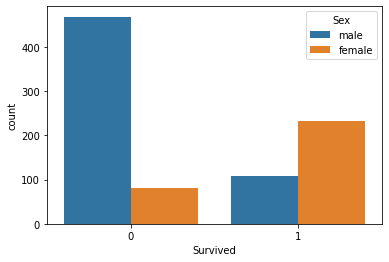

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(train_df["Survived"], hue=train_df["Sex"])

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datas_scale = scaler.fit_transform(datas)
datas_scale = pd.DataFrame(datas_scale, columns=datas.columns)
x_train_scale = datas_scale.iloc[:len(train_df)]
x_test_scale = datas_scale.iloc[len(train_df):]
x_train_scale

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,0.273456,0.125,0.000000,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.1
1,0.473882,0.125,0.000000,0.1,0.139136,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.1
2,0.323563,0.000,0.000000,0.0,0.015469,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.436302,0.125,0.000000,0.1,0.103644,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.1
4,0.436302,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.336089,0.000,0.000000,0.0,0.025374,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
887,0.235876,0.000,0.000000,0.0,0.058556,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
888,0.348616,0.125,0.222222,0.3,0.045771,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3
889,0.323563,0.000,0.000000,0.0,0.058556,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [78]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
params = {
    "n_neighbors": range(5, 100)
}

cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_train_scale, y_train)
print(cv.best_score_)
print(cv.best_params_)

0.832796504369538
{'n_neighbors': 7}


In [79]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(x_train_scale, y_train)
pre = clf.predict(x_test_scale)
result = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
result.to_csv("knn.csv", encoding="utf-8", index=False)
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
